This notebook reproduces (and extends) the plots in
https://wandb.ai/data-frugal-learning/harmonic-learning/reports/Regularized-NN-harmonic-learning--VmlldzoxOTUzNTkx.

It generates paper-ready plots.

### Load libraries

In [1]:
import pathlib
import sys

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
import wandb.apis.public
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src import stylesheets, utils

### Load wandb data

In [2]:
api = wandb.Api()
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/harmonic-learning",
    filters={"tags": {"$in": ["cliff_v2"]}},
)

df_all = utils.runs_to_df(runs)
df = df_all[df_all.state == "finished"]
len(df)

276

### Get pictures of trained network

In [3]:
START_ROW = df.query(
    "net_width == 512 & net_cfg_high_freq_freq_limit == 2 & n_train == n_train.min()"
).iloc[0]
print(
    START_ROW.net_width,
    START_ROW.net_cfg_high_freq_freq_limit,
    START_ROW.n_train,
)

BEST_ROW = df.query("final_val_mse == final_val_mse.min()").iloc[0]
print(
    BEST_ROW.net_width,
    BEST_ROW.net_cfg_high_freq_freq_limit,
    BEST_ROW.n_train,
)

512 2 5
512 2 80


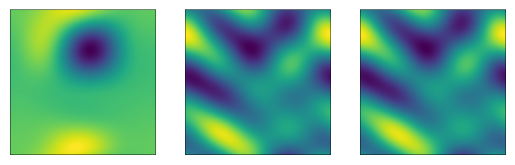

In [4]:
# Get start and best images from runs
plt.subplot(1, 3, 1)
start_img = utils.wandb_get_img(
    api.run(f"data-frugal-learning/harmonic-learning/{START_ROW.id}").file(
        START_ROW.trained_net_path
    )
).crop((143, 57, 514, 428))
plt.imshow(start_img)
plt.axis("off")

plt.subplot(1, 3, 2)
best_img = utils.wandb_get_img(
    api.run(f"data-frugal-learning/harmonic-learning/{BEST_ROW.id}").file(
        BEST_ROW.trained_net_path
    )
).crop((143, 57, 514, 428))
plt.imshow(best_img)
plt.axis("off")

plt.subplot(1, 3, 3)
true_img = utils.wandb_get_img(
    api.run(f"data-frugal-learning/harmonic-learning/{BEST_ROW.id}").file(
        BEST_ROW.true_hf_path
    )
).crop((143, 57, 514, 428))
plt.imshow(true_img)
plt.axis("off")

plt.show()

### Experimental plots

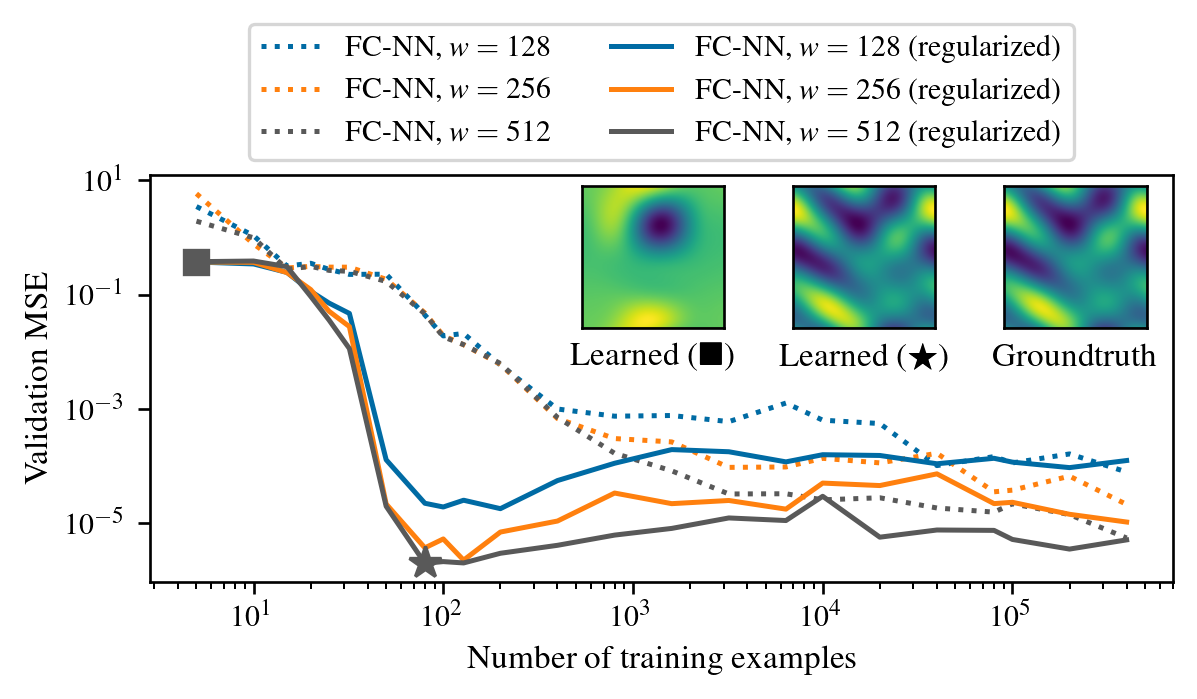

In [5]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')
plt.style.use(
    [
        "tableau-colorblind10",
        stylesheets.ME_FOMO_2023["mplstyle"],
        {
            "pgf.preamble": "\n".join([r"\usepackage{amsmath,amssymb}"]),
        },
    ],
)
width = stylesheets.ME_FOMO_2023["col1_width"]
fig = plt.figure(figsize=(width, 0.4 * width))

for w in [128, 256, 512]:
    cdf = (
        df.query("net_width == @w & net_cfg_high_freq_freq_limit == 0")
        .sort_values("n_train")
        .reset_index(drop=True)
    )
    if w == 512:
        # Cycle color forward by one, skipping light gray
        plt.plot([], [])
    plt.plot(
        cdf.n_train,
        cdf.val_mse,
        label=rf"FC-NN, ${w=}$",
        linestyle=":",
        zorder=-1,
    )

# Reset color cycle
plt.gca().set_prop_cycle(None)
for w in [128, 256, 512]:
    cdf = (
        df.query("net_width == @w & net_cfg_high_freq_freq_limit == 2")
        .sort_values("n_train")
        .reset_index(drop=True)
    )
    if w == 512:
        # Cycle color forward by one, skipping light gray
        plt.plot([], [])
    ax = plt.plot(
        cdf.n_train,
        cdf.val_mse,
        label=rf"FC-NN, ${w=}$ (regularized)",
    )

prev_color = ax[0].get_color()
plt.plot(
    START_ROW.n_train,
    START_ROW.final_val_mse,
    "s",
    markersize=7,
    color=prev_color,
)
plt.plot(
    BEST_ROW.n_train,
    BEST_ROW.final_val_mse,
    "*",
    markersize=10,
    color=prev_color,
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel("Validation MSE")
# Legend on top
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1), ncol=2)

# Plot start_img, best_img, true_img in top right corner
for i, img in enumerate([start_img, best_img, true_img]):
    newax = fig.add_axes(
        [0.3 + 0.16 * i, 0.59, 0.26, 0.27], anchor="NE", zorder=1
    )
    newax.imshow(img)
    # No ticks
    newax.set_xticks([])
    newax.set_yticks([])
    newax.set_xlabel([
        r"Learned ($\blacksquare$)",
        r"Learned ($\bigstar$)",
        r"Groundtruth"
    ][i])
    # Adjust xlabel slightly upwards
    newax.xaxis.set_label_coords(0.5, -0.1)

plt.savefig("figures/nn-harmonic-learning.pgf", bbox_inches="tight")

Thoughts on above figure: Should we also include the learning-curve of an FFT-based algorithm? (I think not, because it doesn't add to the main point of the figure, which is that NNs are able to cliff.)